In [78]:
vars = [var for var in globals() if var[0] != '_']
for var in vars:
    del globals()[var]

del var, vars

In [79]:
import numpy as np
import torch
import scipy.optimize as sci_opt
import sys
sys.path.append('../')
import module_opt, module_opt_AD

import importlib
importlib.reload(module_opt_AD)
importlib.reload(module_opt)

import matplotlib.pyplot as plt


#### Define Functions(obj, constraint)

In [80]:
### Two drones
N = 45 # The number of positions of each drone
T = 15.0 # Total flight time [sec]
vmax = 1.5 # Maximum velocity [unit / sec]

def f(dv):
    N = int(dv.shape[0]/2/2)
    x1 = dv[:N]
    y1 = dv[N:(2*N)]
    C1 = ((np.cos(x1)**2)*(np.cos(y1)**2)).sum()
    d1_sq = np.array([(x1[i+1] - x1[i])**2 + (y1[i+1] - y1[i])**2 for i in np.arange(N-1)]).sum()

    x2 = dv[(2*N):(3*N)]
    y2 = dv[(3*N):]
    C2 = ((np.cos(x2)**2)*(np.cos(y2)**2)).sum()
    d2_sq = np.array([(x2[i+1] - x2[i])**2 + (y2[i+1] - y2[i])**2 for i in np.arange(N-1)]).sum()
    return C1 + d1_sq + C2 + d2_sq

def ce1_1(dv): # x1_1 = 0.0
    N = int(dv.shape[0]/2/2)
    x1 = dv[:N]
    return x1[0]

def ce2_1(dv): # y1_1 = 0.0
    N = int(dv.shape[0]/2/2)
    y1 = dv[N:(2*N)]
    return y1[0]

def ce3_1(dv): # xN_1 = 10.0
    N = int(dv.shape[0]/2/2)
    x1 = dv[:N]
    return x1[-1] - 10.0

def ce4_1(dv): # yN_1 = 10.0
    N = int(dv.shape[0]/2/2)
    y1 = dv[N:(2*N)]
    return y1[-1] - 10.0

def ce5_1(dv): # (x2_1 - x1_1)/(15/(N - 1)) = 0.0 <-> u1 = 0.0
    N = int(dv.shape[0]/2/2)
    x1 = dv[:N]
    return (x1[1] - x1[0])/(T/(N - 1))

def ce6_1(dv): # (y2_1 - y1_1)/(15/(N - 1)) = 0.0 <-> v1 = 0.0
    N = int(dv.shape[0]/2/2)
    y1 = dv[N:(2*N)]
    return (y1[1] - y1[0])/(T/(N - 1))

def ce1_2(dv): # x1_2 = 10.0
    N = int(dv.shape[0]/2/2)
    x2 = dv[(2*N):(3*N)]
    return x2[0] - 10.0

def ce2_2(dv): # y1_2 = 10.0
    N = int(dv.shape[0]/2/2)
    y2 = dv[(3*N):]
    return y2[0] - 10.0

def ce3_2(dv): # xN_2 = 0.0
    N = int(dv.shape[0]/2/2)
    x2 = dv[(2*N):(3*N)]
    return x2[-1]

def ce4_2(dv): # yN_2 = 0.0
    N = int(dv.shape[0]/2/2)
    y2 = dv[(3*N):]
    return y2[-1]

def ce5_2(dv): # (x2_2 - x1_2)/(15/(N - 1)) = 0.0 <-> u1 = 0.0
    N = int(dv.shape[0]/2/2)
    x2 = dv[(2*N):(3*N)]
    return (x2[1] - x2[0])/(T/(N - 1))

def ce6_2(dv): # (y2_2 - y1_2)/(15/(N - 1)) = 0.0 <-> v1 = 0.0
    N = int(dv.shape[0]/2/2)
    y2 = dv[(3*N):]
    return (y2[1] - y2[0])/(T/(N - 1))

ci_x_1_larger_0 = [lambda dv, i=i : dv[i] for i in np.arange(N)] # xi_1 >= 0.0
ci_x_2_larger_0 = [lambda dv, i=i : dv[(2*N)+i] for i in np.arange(N)] # xi_2 >= 0.0

ci_x_1_smaller_10 = [lambda dv, i=i : -dv[i] + 10.0 for i in np.arange(N)] # xi_1 <= 10.0
ci_x_2_smaller_10 = [lambda dv, i=i : -dv[(2*N)+i] + 10.0 for i in np.arange(N)] # xi_2 <= 10.0

ci_y_1_larger_0 = [lambda dv, i=i : dv[N+i] for i in np.arange(N)] # yi_1 >= 0.0
ci_y_2_larger_0 = [lambda dv, i=i : dv[(3*N)+i] for i in np.arange(N)] # yi_2 >= 0.0

ci_y_1_smaller_10 = [lambda dv, i=i : -dv[N+i] + 10.0 for i in np.arange(N)] # yi_1 <= 10.0
ci_y_2_smaller_10 = [lambda dv, i=i : -dv[(3*N)+i] + 10.0 for i in np.arange(N)] # yi_2 <= 10.0

ci_v_1_smaller_vmax = [lambda dv, i=i : vmax**2 - (((dv[i+1] - dv[i])/(T/(N - 1)))**2 + ((dv[N+i+1] - dv[N+i])/(T/(N - 1)))**2) for i in np.arange(N-1)] # vi^2 <= vmax^2
ci_v_2_smaller_vmax = [lambda dv, i=i : vmax**2 - (((dv[(2*N)+i+1] - dv[(2*N)+i])/(T/(N - 1)))**2 + ((dv[(3*N)+i+1] - dv[(3*N)+i])/(T/(N - 1)))**2) for i in np.arange(N-1)] # vi^2 <= vmax^2

ci_prevent_collision = [lambda dv, i=i : (dv[i] - dv[(2*N)+i])**2 + (dv[N+i] - dv[(3*N)+i])**2 - 0.25**2 for i in np.arange(N)] # distance b/w two drones > 0.25

ci = ci_x_1_larger_0 + ci_x_2_larger_0 + ci_x_1_smaller_10 + ci_x_2_smaller_10 + ci_y_1_larger_0 + ci_y_2_larger_0 + ci_y_1_smaller_10 + ci_y_2_smaller_10 + ci_v_1_smaller_vmax + ci_v_2_smaller_vmax + ci_prevent_collision

#### Define Functions(obj, constraint) using torch

In [81]:
# ---- 목적함수 (torch 버전) ----
def f_torch(dv: torch.Tensor) -> torch.Tensor:
    """
    dv: (4N,) torch.Tensor
    return: scalar torch.Tensor
    """
    dv = dv.flatten()
    N_local = dv.numel() // 4

    x1 = dv[:N_local]
    y1 = dv[N_local:(2 * N_local)]
    x2 = dv[(2 * N_local):(3 * N_local)]
    y2 = dv[(3 * N_local):]

    C1 = torch.sum(torch.cos(x1) ** 2 * torch.cos(y1) ** 2)
    d1_sq = torch.sum((x1[1:] - x1[:-1]) ** 2 + (y1[1:] - y1[:-1]) ** 2)

    C2 = torch.sum(torch.cos(x2) ** 2 * torch.cos(y2) ** 2)
    d2_sq = torch.sum((x2[1:] - x2[:-1]) ** 2 + (y2[1:] - y2[:-1]) ** 2)

    return C1 + d1_sq + C2 + d2_sq


# ---- 등호 제약 1번 드론 (각각 함수) ----
def ce1_1_torch(dv: torch.Tensor) -> torch.Tensor:  # x1_1 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    x1 = dv[:N_local]
    return x1[0]


def ce2_1_torch(dv: torch.Tensor) -> torch.Tensor:  # y1_1 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    y1 = dv[N_local:(2 * N_local)]
    return y1[0]


def ce3_1_torch(dv: torch.Tensor) -> torch.Tensor:  # xN_1 = 10.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    x1 = dv[:N_local]
    return x1[-1] - 10.0


def ce4_1_torch(dv: torch.Tensor) -> torch.Tensor:  # yN_1 = 10.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    y1 = dv[N_local:(2 * N_local)]
    return y1[-1] - 10.0


def ce5_1_torch(dv: torch.Tensor) -> torch.Tensor:  # u1_1 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    x1 = dv[:N_local]
    dt = T / (N_local - 1)
    return (x1[1] - x1[0]) / dt


def ce6_1_torch(dv: torch.Tensor) -> torch.Tensor:  # v1_1 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    y1 = dv[N_local:(2 * N_local)]
    dt = T / (N_local - 1)
    return (y1[1] - y1[0]) / dt


# ---- 등호 제약 2번 드론 (각각 함수) ----
def ce1_2_torch(dv: torch.Tensor) -> torch.Tensor:  # x1_2 = 10.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    x2 = dv[(2 * N_local):(3 * N_local)]
    return x2[0] - 10.0


def ce2_2_torch(dv: torch.Tensor) -> torch.Tensor:  # y1_2 = 10.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    y2 = dv[(3 * N_local):]
    return y2[0] - 10.0


def ce3_2_torch(dv: torch.Tensor) -> torch.Tensor:  # xN_2 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    x2 = dv[(2 * N_local):(3 * N_local)]
    return x2[-1] - 0.0


def ce4_2_torch(dv: torch.Tensor) -> torch.Tensor:  # yN_2 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    y2 = dv[(3 * N_local):]
    return y2[-1] - 0.0


def ce5_2_torch(dv: torch.Tensor) -> torch.Tensor:  # u1_2 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    x2 = dv[(2 * N_local):(3 * N_local)]
    dt = T / (N_local - 1)
    return (x2[1] - x2[0]) / dt


def ce6_2_torch(dv: torch.Tensor) -> torch.Tensor:  # v1_2 = 0.0
    dv = dv.flatten()
    N_local = dv.numel() // 4
    y2 = dv[(3 * N_local):]
    dt = T / (N_local - 1)
    return (y2[1] - y2[0]) / dt


# ---- 부등호 제약 (각각 함수화 후 리스트에 저장) ----
# 0 <= x1_i <= 10, 0 <= y1_i <= 10, 0 <= x2_i <= 10, 0 <= y2_i <= 10
# v1_i^2 <= vmax^2, v2_i^2 <= vmax^2
# -> h(dv) >= 0 형태로 맞춤

# 위치 bounds
ci_x_1_larger_0_torch = [
    (lambda dv, i=i: dv.flatten()[i])
    for i in range(N)
]  # x1_i >= 0

ci_x_2_larger_0_torch = [
    (lambda dv, i=i: dv.flatten()[2 * N + i])
    for i in range(N)
]  # x2_i >= 0

ci_x_1_smaller_10_torch = [
    (lambda dv, i=i: 10.0 - dv.flatten()[i])
    for i in range(N)
]  # x1_i <= 10  -> 10 - x1_i >= 0

ci_x_2_smaller_10_torch = [
    (lambda dv, i=i: 10.0 - dv.flatten()[2 * N + i])
    for i in range(N)
]  # x2_i <= 10  -> 10 - x2_i >= 0

ci_y_1_larger_0_torch = [
    (lambda dv, i=i: dv.flatten()[N + i])
    for i in range(N)
]  # y1_i >= 0

ci_y_2_larger_0_torch = [
    (lambda dv, i=i: dv.flatten()[3 * N + i])
    for i in range(N)
]  # y2_i >= 0

ci_y_1_smaller_10_torch = [
    (lambda dv, i=i: 10.0 - dv.flatten()[N + i])
    for i in range(N)
]  # y1_i <= 10 -> 10 - y1_i >= 0

ci_y_2_smaller_10_torch = [
    (lambda dv, i=i: 10.0 - dv.flatten()[3 * N + i])
    for i in range(N)
]  # y2_i <= 10 -> 10 - y2_i >= 0


# 속도 제약: vmax^2 - (vx_i^2 + vy_i^2) >= 0
ci_v_1_smaller_vmax_torch = [
    (
        lambda dv, i=i: (
            vmax**2
            - (
                ((dv.flatten()[i + 1] - dv.flatten()[i]) / (T / (N - 1))) ** 2
                + (
                    (dv.flatten()[N + i + 1] - dv.flatten()[N + i])
                    / (T / (N - 1))
                )
                ** 2
            )
        )
    )
    for i in range(N - 1)
]

ci_v_2_smaller_vmax_torch = [
    (
        lambda dv, i=i: (
            vmax**2
            - (
                (
                    dv.flatten()[2 * N + i + 1]
                    - dv.flatten()[2 * N + i]
                )
                / (T / (N - 1))
            )
            ** 2
            - (
                (
                    dv.flatten()[3 * N + i + 1]
                    - dv.flatten()[3 * N + i]
                )
                / (T / (N - 1))
            )
            ** 2
        )
    )
    for i in range(N - 1)
]

ci_prevent_collision_torch = [
    (lambda dv, i=i:
        (dv.flatten()[i]        - dv.flatten()[2*N + i])**2 +
        (dv.flatten()[N + i]    - dv.flatten()[3*N + i])**2
        - (0.25**2)
    )
    for i in range(N)
]

ci_torch = ci_x_1_larger_0_torch + ci_x_2_larger_0_torch + ci_x_1_smaller_10_torch + ci_x_2_smaller_10_torch + ci_y_1_larger_0_torch + ci_y_2_larger_0_torch + ci_y_1_smaller_10_torch + ci_y_2_smaller_10_torch + ci_v_1_smaller_vmax_torch + ci_v_2_smaller_vmax_torch + ci_prevent_collision_torch

#### Set Initial Guess(dv0) 

In [82]:
def make_dv0(N=45, min_dist=0.25, A=0.5):
    s = np.linspace(0.0, 1.0, N)

    # ----- Drone 1: (0,0) -> (10,10) 직선 + 위쪽 offset -----
    x1_base = 10.0 * s
    y1_base = 10.0 * s

    # y = x 에 수직인 단위벡터 (위쪽 방향)
    n1_x = -1.0 / np.sqrt(2.0)
    n1_y =  1.0 / np.sqrt(2.0)

    offset1 = A * np.sin(np.pi * s)
    x1 = x1_base + offset1 * n1_x
    y1 = y1_base + offset1 * n1_y

    # ----- Drone 2: (10,10) -> (0,0) 직선 + 아래쪽 offset -----
    x2_base = 10.0 * (1.0 - s)
    y2_base = 10.0 * (1.0 - s)

    n2_x =  1.0 / np.sqrt(2.0)
    n2_y = -1.0 / np.sqrt(2.0)

    offset2 = A * np.sin(np.pi * s)
    x2 = x2_base + offset2 * n2_x
    y2 = y2_base + offset2 * n2_y

    dv0 = np.concatenate([x1, y1, x2, y2])
    return dv0

dv0 = make_dv0(N=N)

### scipy.optimize 사용하여 풀기

In [91]:
# 1) equality constraints
eq_constraints = [
    {'type': 'eq', 'fun': ce1_1},
    {'type': 'eq', 'fun': ce2_1},
    {'type': 'eq', 'fun': ce3_1},
    {'type': 'eq', 'fun': ce4_1},
    {'type': 'eq', 'fun': ce5_1},
    {'type': 'eq', 'fun': ce6_1},
    {'type': 'eq', 'fun': ce1_2},
    {'type': 'eq', 'fun': ce2_2},
    {'type': 'eq', 'fun': ce3_2},
    {'type': 'eq', 'fun': ce4_2},
    {'type': 'eq', 'fun': ce5_2},
    {'type': 'eq', 'fun': ce6_2},
]

# 2) inequality constraints
ineq_constraints = []

for c in ci_x_1_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_x_1_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_1_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_1_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_v_1_smaller_vmax:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_x_2_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_x_2_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_2_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_2_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_v_2_smaller_vmax:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_prevent_collision:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

# 3) 모두 합치기
constraints = eq_constraints + ineq_constraints

In [92]:
# ------------------------------------------------------------------ xk Log of SLSQP ------------------------------------------------------------------
x_slsqp = []
def cb(xk):
    x_slsqp.append(xk.copy())

In [93]:
x_slsqp.append(dv0)
res = sci_opt.minimize(
    fun=f,
    x0=dv0,
    method='SLSQP',
    constraints=constraints,
    options={'ftol': 1e-8, 'maxiter': 1000, 'disp': True},
    callback=cb
)

print("success:", res.success)
print("message:", res.message)
print("f_min:", res.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.654039879852082
            Iterations: 120
            Function evaluations: 21885
            Gradient evaluations: 120
success: True
message: Optimization terminated successfully
f_min: 22.654039879852082


In [83]:
def plot_two_drones_paths(x_opt, N, K):
    """
    x_opt: list (or iterable) of dv history, length K
           dv: 1D array-like, length 4N = [x1, y1, x2, y2]
    N    : number of positions per drone
    K    : number of iterations (len(x_opt))
    """

    plt.figure(figsize=(6, 6))

    for k, dv in enumerate(x_opt):
        dv = np.asarray(dv)
        # 드론 1
        x1 = dv[:N]
        y1 = dv[N:2*N]
        # 드론 2
        x2 = dv[2*N:3*N]
        y2 = dv[3*N:4*N]

        alpha = 0.1 + 0.9 * (k / (K - 1)) if K > 1 else 1.0

        # 마지막 이전까지는 점선
        if k != (K - 1):
            # 드론 1: 파란색 점선
            if k == K - 2:
                plt.plot(x1, y1, color='blue', linestyle='--', alpha=alpha,
                         label='Drone 1 (iterates)')
                plt.plot(x2, y2, color='green', linestyle='--', alpha=alpha,
                         label='Drone 2 (iterates)')
            else:
                plt.plot(x1, y1, color='blue', linestyle='--', alpha=alpha)
                plt.plot(x2, y2, color='green', linestyle='--', alpha=alpha)
        else:
            # 마지막: 최종 trajectory
            # 드론 1: 빨간 실선
            plt.plot(x1, y1, color='red', linewidth=3, alpha=alpha,
                     label='Drone 1 (x*)')
            # 드론 2: 마젠타 실선
            plt.plot(x2, y2, color='magenta', linewidth=3, alpha=alpha,
                     label='Drone 2 (x*)')

    # 시작점 / 끝점 강조 (드론1: 0,0→10,10 / 드론2: 10,10→0,0)
    # Drone 1
    plt.scatter([0], [0], color='cyan', s=80, marker='o',
                edgecolors='k', label='Drone 1 Start (0,0)')
    plt.scatter([10], [10], color='black', s=80, marker='o',
                edgecolors='k', label='Drone 1 Goal (10,10)')

    # Drone 2
    plt.scatter([10], [10], color='yellow', s=80, marker='s',
                edgecolors='k', label='Drone 2 Start (10,10)')
    plt.scatter([0], [0], color='orange', s=80, marker='s',
                edgecolors='k', label='Drone 2 Goal (0,0)')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Two Drones Iteration Paths")
    plt.grid(True)
    plt.axis('equal')

    # 중복 레전드 정리
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best')

    plt.show()

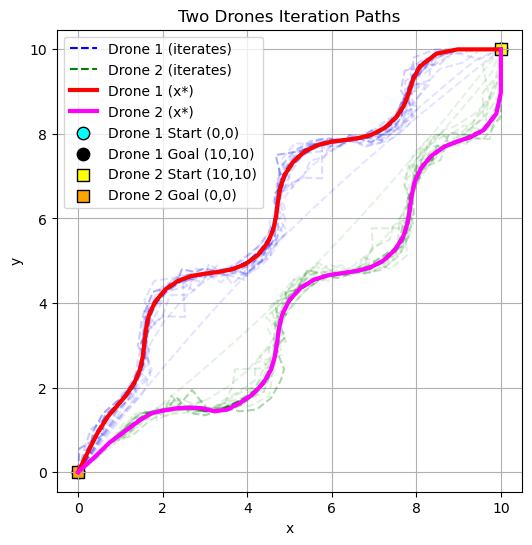

In [94]:
plot_two_drones_paths(x_slsqp, N, len(x_slsqp))

Text(0, 0.5, 'f(xk)')

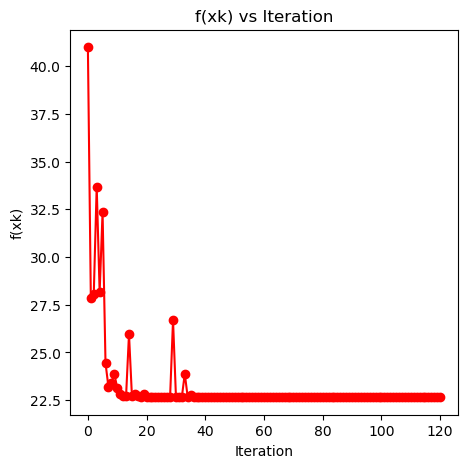

In [95]:
log_f_slsqp = np.array([f(x_k) for x_k in x_slsqp])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(log_f_slsqp, marker='o', color='red')
axes.set_title('f(xk) vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('f(xk)')

In [96]:
log_f_slsqp[-1]

np.float64(22.654039883783057)

Text(0, 0.5, '|ci(xk)|')

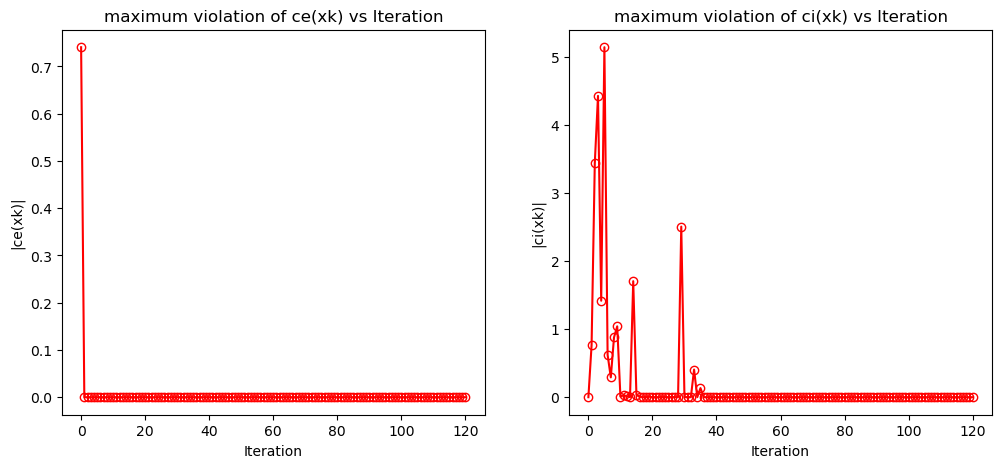

In [97]:
list_max_ce_slsqp = []
list_max_ci_slsqp = []
for x_k in x_slsqp:
    list_max_ce_slsqp.append(max(abs(ce1_1(x_k)), abs(ce2_1(x_k)), abs(ce3_1(x_k)), abs(ce4_1(x_k)), abs(ce5_1(x_k)), abs(ce6_1(x_k)), abs(ce1_2(x_k)), abs(ce2_2(x_k)), abs(ce3_2(x_k)), abs(ce4_2(x_k)), abs(ce5_2(x_k)), abs(ce6_2(x_k))))
    list_max_ci_slsqp.append(max([abs(min(ci_i(x_k), 0)) for ci_i in ci]))

fig, axes = plt.subplots(1, 2, figsize=(6*2, 5))
axes[0].plot(list_max_ce_slsqp, marker='o', color='red', markerfacecolor='none')
axes[0].set_title('maximum violation of ce(xk) vs Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('|ce(xk)|')

axes[1].plot(list_max_ci_slsqp, marker='o', color='red', markerfacecolor='none')
axes[1].set_title('maximum violation of ci(xk) vs Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('|ci(xk)|')

In [98]:
print(f'last_ce_slsqp : {list_max_ce_slsqp[-1]}')
print(f'last_ci_slsqp : {list_max_ci_slsqp[-1]}')

last_ce_slsqp : 1.9307586178347258e-22
last_ci_slsqp : 2.5863133856773857e-10


#### 내가 짠 SQP 사용 시
---
<등간격으로 dv0 선정 시>  
QP 부문제가 feasible한데도 불구하고 alm4sqp가 QP 부문제의 해를 찾지 못함  
1. ∇L_A이 감소하지 않고 커짐
2. 제약함수(ce_QPk, ci_QPk)의 값이 0을 만족하지 못함
3. 제약함수 값이 어느 정도 작아진 상태에서도 목적함수(Q_QPk) 값이 줄지 않고 계속 늘어남  

결국 alm4sqp가 QP 부문제를 잘 풀지 못한다는 얘기. 왜인지는 모르겠음.  

---

<난수 생성해서 dv0 선정 시>  
너무 신기하게도 잘 풀림(!)  
비록 30분 걸리기는 했지만 어쨌든 해를 찾았음!

In [84]:
# 직선 기본 경로
x_base = np.linspace(0, 10, N)
y_base = np.linspace(0, 10, N)

# 난수 perturbation (작은 magnitude)
eps = 3.0   # 난수 perturbation 크기
x0_1 = x_base + np.random.uniform(-eps, eps, size=N)
y0_1 = y_base + np.random.uniform(-eps, eps, size=N)
x0_2 = x_base + np.random.uniform(-eps, eps, size=N)
y0_2 = y_base + np.random.uniform(-eps, eps, size=N)

# 시작/끝은 다시 고정
x0_1[0], y0_1[0] = 0.0, 0.0
x0_1[-1], y0_1[-1] = 10.0, 10.0
x0_2[0], y0_2[0] = 10.0, 10.0
x0_2[-1], y0_2[-1] = 0.0, 0.0

dv0_sqp = np.concatenate([x0_1, y0_1, x0_2, y0_2])

log_opt_AD_sqp = module_opt_AD.sqp(f=f, 
                                   f_torch=f_torch, 
                                   ce=[ce1_1, ce2_1, ce3_1, ce4_1, ce5_1, ce6_1, ce1_2, ce2_2, ce3_2, ce4_2, ce5_2, ce6_2],
                                   ce_torch=[ce1_1_torch, ce2_1_torch, ce3_1_torch, ce4_1_torch, ce5_1_torch, ce6_1_torch, ce1_2_torch, ce2_2_torch, ce3_2_torch, ce4_2_torch, ce5_2_torch, ce6_2_torch],
                                   ci=ci, 
                                   ci_torch=ci_torch, 
                                   x0=dv0, 
                                   maxiter=20, 
                                   inner_opt=3, 
                                   tol=1e-6, 
                                   tol_inter=1e-3)
# log_opt_AD_sqp = module_opt_AD.sqp(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, maxiter=40, inner_opt=3, tol=1e-6, tol_inter=1e-3)


 log - ALM
‖∆p‖ = 5.05e+00, p01 = [0.37584069, 0.21418482, 0.36156577, 0.49590045, 0.28473452, 0.08531836, 0.00385786, 0.01217277, -0.01828864, -0.19941346, -0.51955383, -0.78602471, -0.74475772, -0.64521386, -0.47980400, -0.25927823, 0.00105323, 0.17576759, 0.07630841, 0.00588407, 0.03202804, 0.09249365, 0.05064942, -0.18187339, -0.55296297, -0.82856420, -0.75746528, -0.63512914, -0.45493193, -0.21967296, 0.06111350, 0.20879649, 0.09739640, 0.01261975, 0.00954879, 0.02302049, -0.06447271, -0.30450789, -0.61178827, -0.64029383, -0.45635759, -0.26120864, -0.05563910, 0.19482057, 0.04592485, 0.47053035, 0.26871484, 0.47432288, 0.67325114, 0.42823029, 0.16203370, 0.01296003, -0.00991820, -0.00437738, -0.06832375, -0.19884947, -0.22676632, 0.06315107, 0.31773957, 0.52528807, 0.68093687, 0.78684032, 0.73172470, 0.35591851, 0.04069282, -0.09097515, -0.06464723, -0.00776594, -0.02933169, -0.12302563, -0.11817312, 0.16799893, 0.41566817, 0.61092261, 0.74083090, 0.80423988, 0.68048915, 0.32803

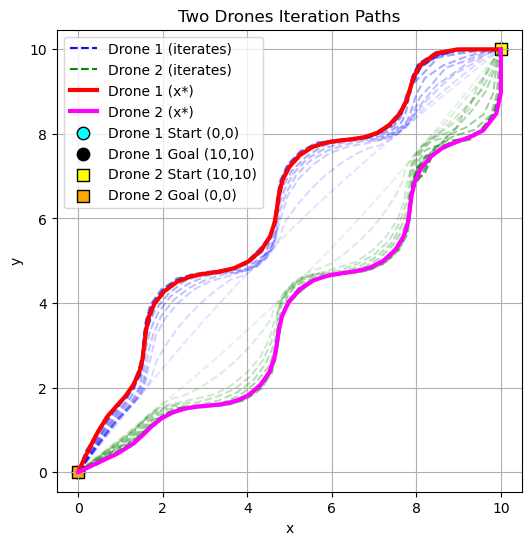

In [85]:
plot_two_drones_paths(log_opt_AD_sqp[0], N, len(log_opt_AD_sqp[0]))

Text(0, 0.5, 'f(xk)')

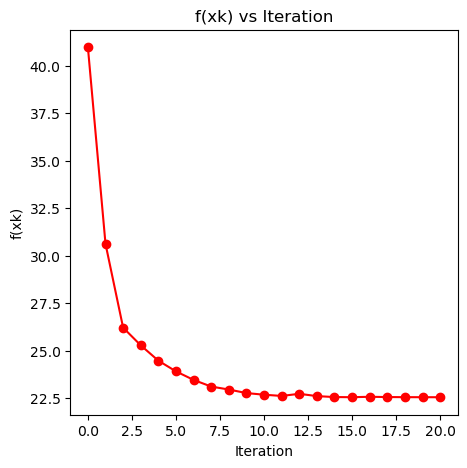

In [86]:
f_sqp = np.array(log_opt_AD_sqp[1])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(f_sqp, marker='o', color='red')
axes.set_title('f(xk) vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('f(xk)')

In [87]:
f_sqp[-1]

np.float64(22.54027130651933)

Text(0, 0.5, '|∇L|')

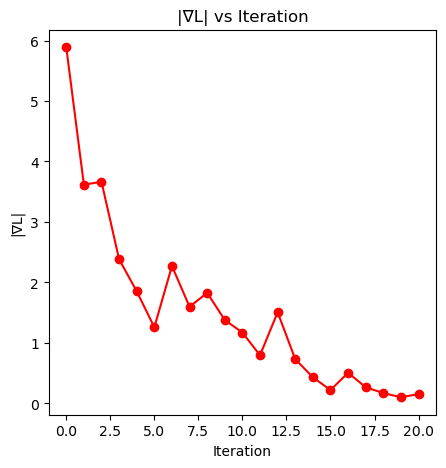

In [88]:
grad_L_sqp = np.array(log_opt_AD_sqp[3])
norm_grad_L_sqp = np.array([np.linalg.norm(grad_L_sqp[i]) for i in range(grad_L_sqp.shape[0])])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(norm_grad_L_sqp, marker='o', color='red')
axes.set_title('|∇L| vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('|∇L|')

In [99]:
norm_grad_L_sqp[-1]

np.float64(0.15344859047451678)

Text(0, 0.5, '|ci(xk)|')

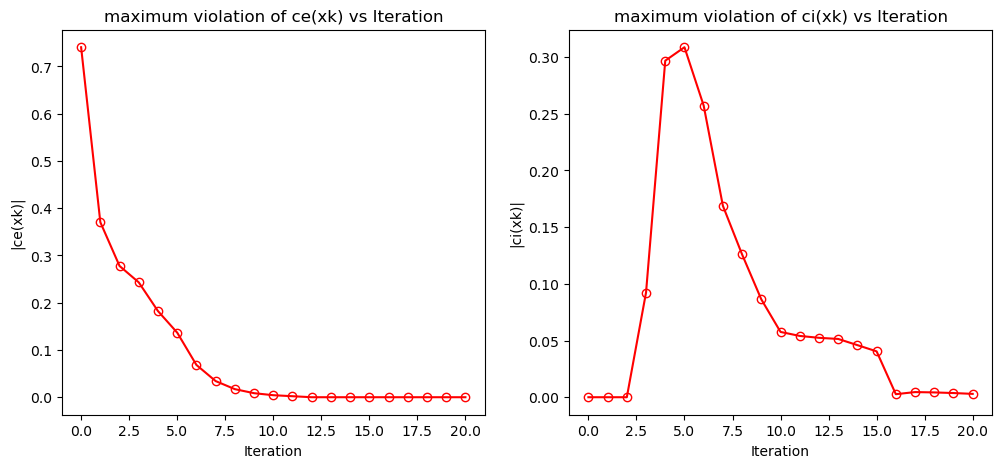

In [89]:
list_max_ce_sqp = [max(np.abs(np.array(ce_k))) for ce_k in log_opt_AD_sqp[4]]
list_max_ci_sqp = np.abs(np.array([np.min(np.minimum(np.array(ci_k), 0)) for ci_k in log_opt_AD_sqp[5]]))

fig, axes = plt.subplots(1, 2, figsize=(6*2, 5))
axes[0].plot(list_max_ce_sqp, marker='o', color='red', markerfacecolor='none')
axes[0].set_title('maximum violation of ce(xk) vs Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('|ce(xk)|')

axes[1].plot(list_max_ci_sqp, marker='o', color='red', markerfacecolor='none')
axes[1].set_title('maximum violation of ci(xk) vs Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('|ci(xk)|')

In [90]:
print(f'max_ce_sqp : {list_max_ce_sqp[-1]}')
print(f'max_ci_sqp : {list_max_ci_sqp[-1]}')

max_ce_sqp : 2.1541872900456643e-06
max_ci_sqp : 0.002952826600984171
